# Análisis Exploratorio del Dataset - Obligatorio Taller de Deep Learning

**Alumno(s):** Ramiro Sanes, Joaquin Guerra


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from collections import Counter
import pandas as pd
import seaborn as sns

np.random.seed(42)

## 1. Información Básica del Dataset

Verificamos la estructura de directorios y contamos el número de imágenes disponibles.

In [4]:
train_images_dir = "train/images"
train_masks_dir = "train/masks"
test_images_dir = "test/images"

train_images = sorted(os.listdir(train_images_dir)) if os.path.exists(train_images_dir) else []
train_masks = sorted(os.listdir(train_masks_dir)) if os.path.exists(train_masks_dir) else []
test_images = sorted(os.listdir(test_images_dir)) if os.path.exists(test_images_dir) else []

print(f"  - Imágenes de entrenamiento: {len(train_images)}")
print(f"  - Máscaras de entrenamiento: {len(train_masks)}")
print(f"  - Imágenes de test: {len(test_images)}")

if len(train_images) == len(train_masks):
    print("  - El número de imágenes y máscaras de entrenamiento coincide.")
else:
    print("  - El número de imágenes y máscaras de entrenamiento NO coincide.")

  - Imágenes de entrenamiento: 2133
  - Máscaras de entrenamiento: 2133
  - Imágenes de test: 534
  - El número de imágenes y máscaras de entrenamiento coincide.


## 2. Análisis de Dimensiones y Formatos

In [6]:
sample_size = 50

image_sizes = []
mask_sizes = []
image_modes = []
mask_modes = []

for i in range(sample_size):
    # Cargamos la imagen
    img_path = os.path.join(train_images_dir, train_images[i])
    img = Image.open(img_path)
    image_sizes.append(img.size)
    image_modes.append(img.mode)
    
    # Cargamos la mascara
    mask_path = os.path.join(train_masks_dir, train_masks[i])
    mask = Image.open(mask_path)
    mask_sizes.append(mask.size)
    mask_modes.append(mask.mode)

# traemos los valores unicos para analizarlos
unique_img_sizes = list(set(image_sizes))
unique_mask_sizes = list(set(mask_sizes))
unique_img_modes = list(set(image_modes))
unique_mask_modes = list(set(mask_modes))

print(f"\n Dimensiones únicas de imágenes: {unique_img_sizes}")
print(f" Dimensiones únicas de máscaras: {unique_mask_sizes}")
print(f"\n Formatos en las imágenes: {unique_img_modes}")
print(f" Formatos en las máscaras: {unique_mask_modes}")

if len(unique_img_sizes) == 1:
    print(f"\n Todas las imágenes tienen el mismo tamaño: {unique_img_sizes[0]}")
else:
    print(f"\n Hay imágenes de diferentes tamaños vamos a tener que redimensionarlas")
    
if len(unique_mask_sizes) == 1:
    print(f" Todas las máscaras tienen el mismo tamaño: {unique_mask_sizes[0]}")
else:
    print(f" Hay máscaras de diferentes tamaños")


 Dimensiones únicas de imágenes: [(800, 800)]
 Dimensiones únicas de máscaras: [(800, 800)]

 Formatos en las imágenes: ['RGB']
 Formatos en las máscaras: ['RGB']

 Todas las imágenes tienen el mismo tamaño: (800, 800)
 Todas las máscaras tienen el mismo tamaño: (800, 800)


Observamos que todas las imágenes y máscaras tienen el mismo tamaño (800x800), por lo que no necesitamos redimensionarlas para unificar tamaños. Las decisiones sobre aplicar o no resize al transformarlas estarán basadas únicamente en qué tan grandes queremos que sean las imágenes que pasamos a la red.

Tanto las imágenes como las máscaras estan todas en formato "RGB". Las máscaras las vamos a tranformar para que tengan 1 solo canal.

## 3. Visualización de Ejemplos

Mostramos algunos ejemplos de imágenes junto con sus máscaras para entender visualmente el problema de segmentación.

Observamos 5 ejemplos aleatorios del dataset:


EJEMPLO 1


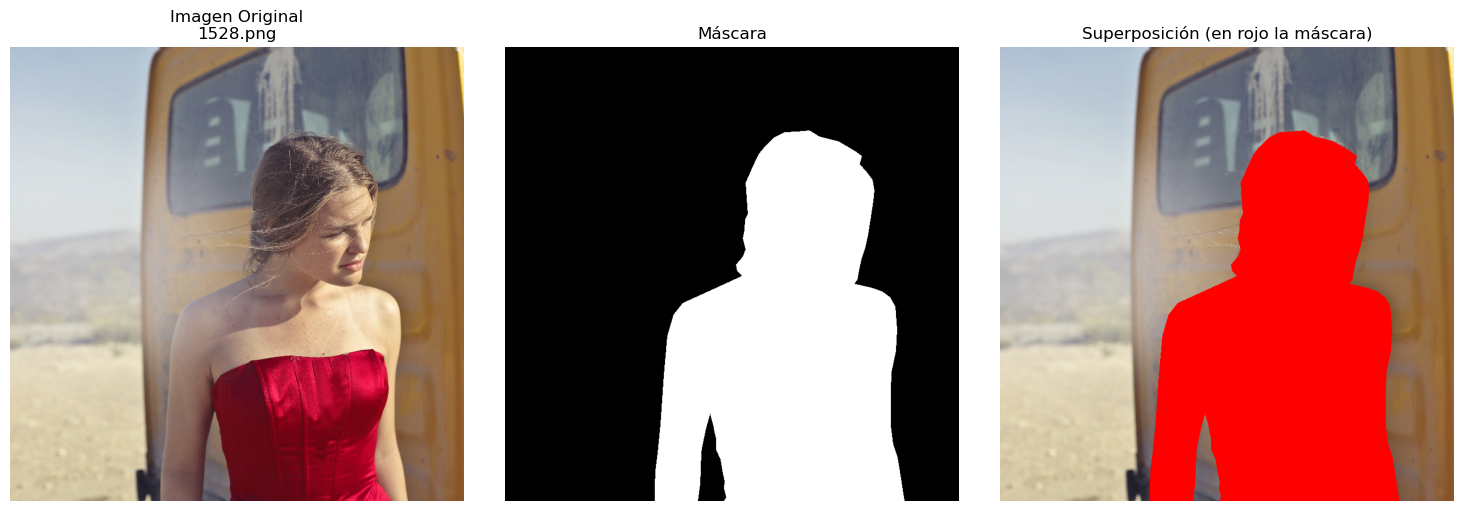

  - Pixeles totales: 640,000
  - Pixeles positivos: 202,751
  - Cobertura (%): 31.68%

EJEMPLO 2


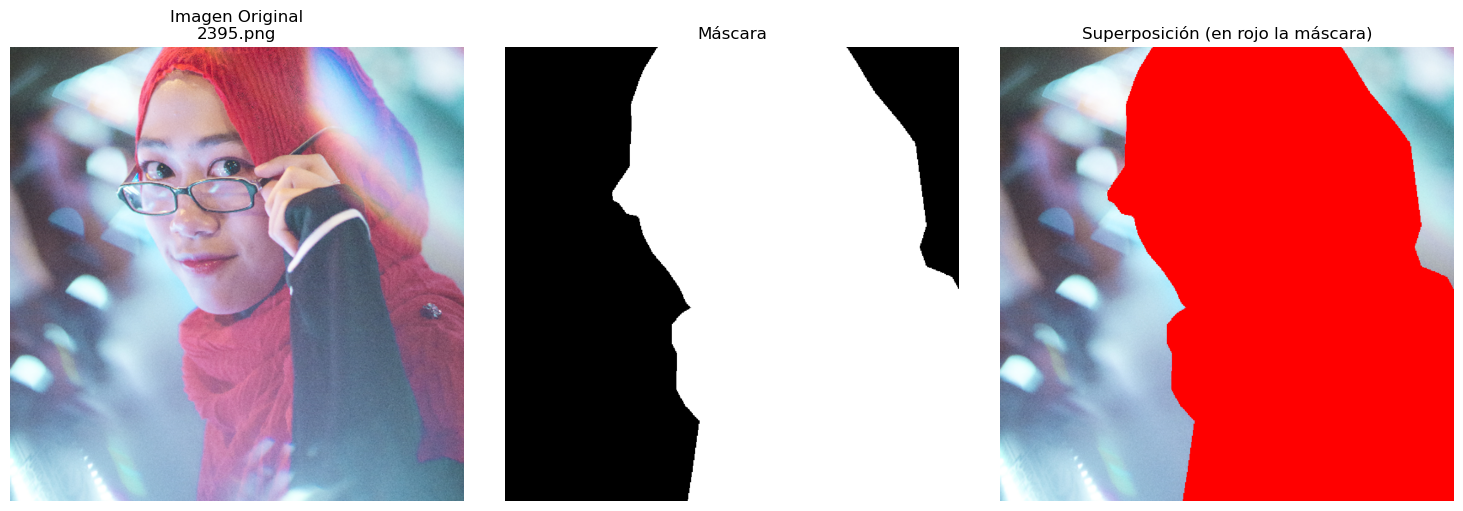

  - Pixeles totales: 640,000
  - Pixeles positivos: 382,164
  - Cobertura (%): 59.71%

EJEMPLO 3


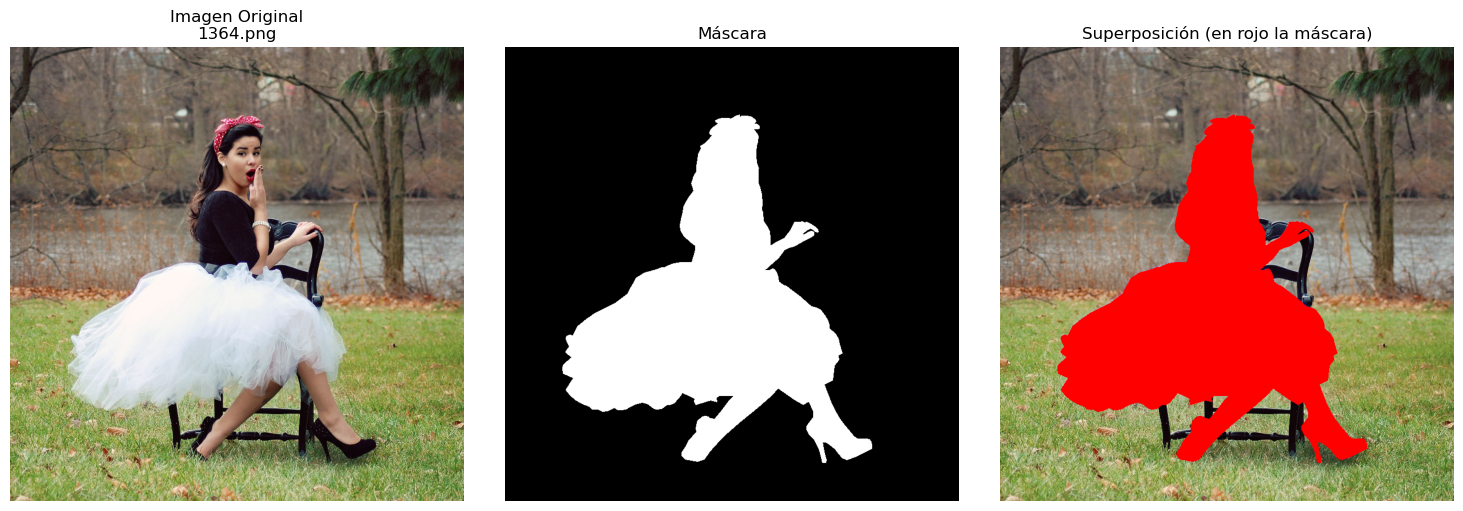

  - Pixeles totales: 640,000
  - Pixeles positivos: 143,367
  - Cobertura (%): 22.40%

EJEMPLO 4


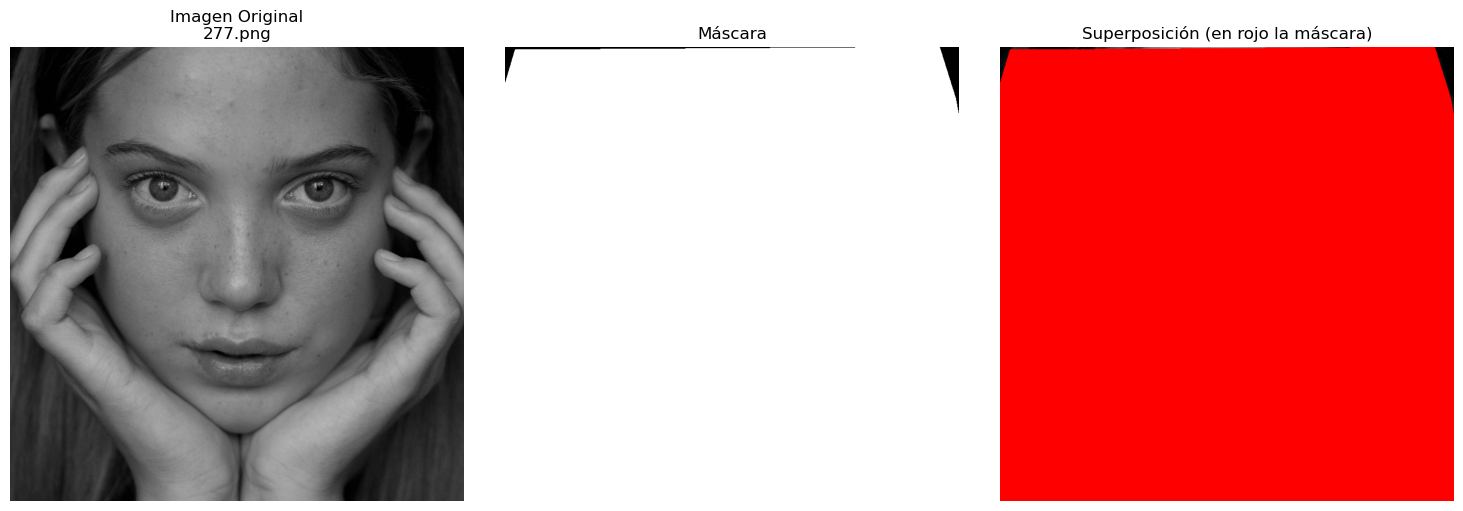

  - Pixeles totales: 640,000
  - Pixeles positivos: 636,058
  - Cobertura (%): 99.38%

EJEMPLO 5


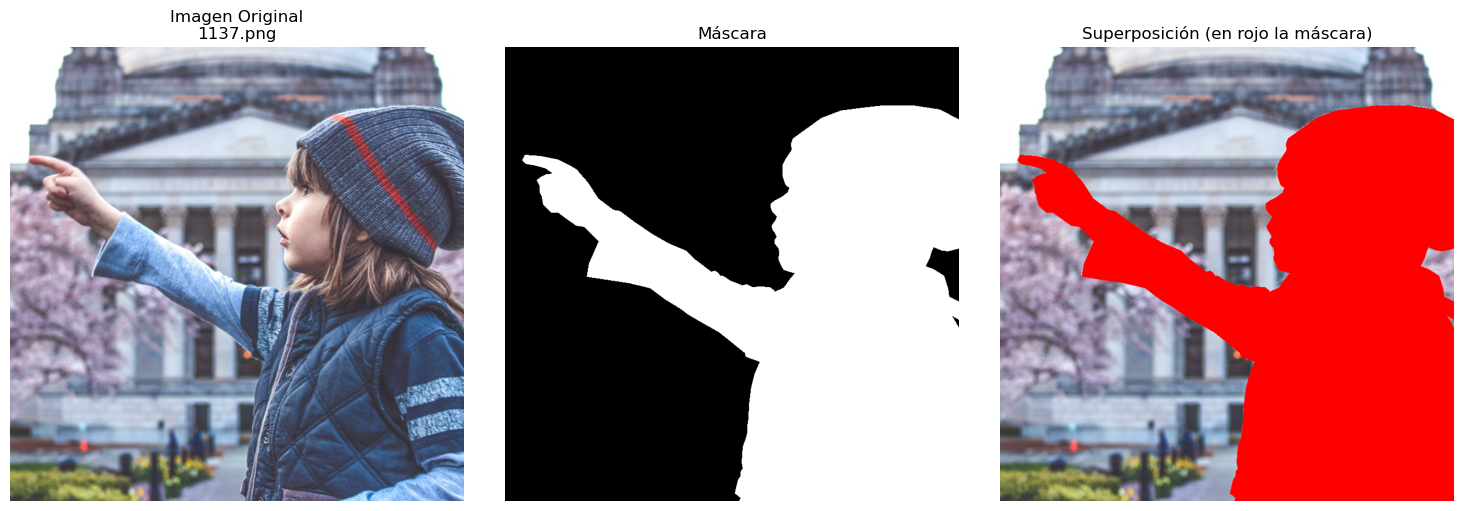

  - Pixeles totales: 640,000
  - Pixeles positivos: 272,568
  - Cobertura (%): 42.59%


In [ ]:
# Función para visualizar imagen + máscara + superposición
def visualize_sample(idx, images_dir, masks_dir, images_list, masks_list):
    """Visualiza una imagen, su máscara y la superposición."""
    # Cargamos la imágen y su máscara
    img_path = os.path.join(images_dir, images_list[idx])
    mask_path = os.path.join(masks_dir, masks_list[idx])
    
    img = Image.open(img_path)
    # Convertimos la mascara a escala de grises para visualizar mejor
    mask = Image.open(mask_path).convert('L')
    
    # Convertimos las imagenes y mascaras a arrays numpy
    img_np = np.array(img)
    mask_np = np.array(mask)
    
    # Creamos la imagen de superposición (imagen con máscara transparente)
    # copiamos la imagen original
    overlay = img_np.copy()
    # donde la mascara es mayor a 0, ponemos rojo
    overlay[mask_np > 0] = [255, 0, 0] 
    
    # Crear figura
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_np)
    axes[0].set_title(f'Imagen Original\n{images_list[idx]}')
    axes[0].axis('off')
    
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Máscara')
    axes[1].axis('off')
    
    axes[2].imshow(overlay)
    axes[2].set_title('Superposición (en rojo la máscara)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    

    pixeles_totales = mask_np.size
    pixeles_positivos = np.sum(mask_np > 0)
    cobertura = (pixeles_positivos / pixeles_totales) * 100
    
    print(f"  - Pixeles totales: {pixeles_totales:,}")
    print(f"  - Pixeles positivos: {pixeles_positivos:,}")
    print(f"  - Cobertura (%): {cobertura:.2f}%")

# Mostramos 5 ejemplos aleatorios
num_samples = 5
print(f"Observamos {num_samples} ejemplos aleatorios del dataset:\n")

for i in range(num_samples):
    idx = np.random.randint(0, len(train_images))
    print(f"\n{'='*60}")
    print(f"EJEMPLO {i+1}")
    print('='*60)
    visualize_sample(idx, train_images_dir, train_masks_dir, train_images, train_masks)

Se observa que la cobertura de la mascara es bastante alta pero variable entre distintas imagenes. 
- En general, las máscaras ocupan una porción importante de la imagen, no estamos segmentando objetos diminutos.
- Hay mucha variabilidad en los tamaños de las mascaras, observamos coberturas desde 20% hasta 99%

Existe cierto desbalance entre los pixeles clasificados como 1 y pixeles clasificados como 0, pero no vemos un desbalance extremo. Por lo que creemos que utilizar tanto BCE como Dice como función de perdida son opciones válidas.

## 4. Análisis de las Máscaras

In [ ]:
pct_cobertura = []
lista_pixeles_positivos = []
lista_pixeles_totales = []

for i, mask_file in enumerate(train_masks):
    
    mask_path = os.path.join(train_masks_dir, mask_file)

    # Las cargamos y convertimos a escala de grises
    mask = np.array(Image.open(mask_path).convert('L'))
    
    total_pixels = mask.size
    positive_pixels = np.sum(mask > 0)
    coverage = (positive_pixels / total_pixels) * 100
    
    pct_cobertura.append(coverage)
    lista_pixeles_positivos.append(positive_pixels)
    lista_pixeles_totales.append(total_pixels)


# Calculamos metricas globales
pixeles_totales = np.sum(lista_pixeles_totales)
pixeles_totales_positivos = np.sum(lista_pixeles_positivos)
pixeles_totales_negativos = pixeles_totales - pixeles_totales_positivos

cobertura_total = (pixeles_totales_positivos / pixeles_totales) * 100

print(f"\n Píxeles totales en el dataset: {pixeles_totales:,}")
print(f"  - Píxeles positivos: {pixeles_totales_positivos:,}")
print(f"  - Píxeles negativos: {pixeles_totales_negativos:,}")
print(f"\n  Cobertura promedio: {cobertura_total:.2f}%")

print(f"\n Valores por imagen:")
print(f"   - Mínimo: {np.min(pct_cobertura):.2f}%")
print(f"   - Máximo: {np.max(pct_cobertura):.2f}%")
print(f"   - Media: {np.mean(pct_cobertura):.2f}%")
print(f"   - Mediana: {np.median(pct_cobertura):.2f}%")
print(f"   - Desv. estándar: {np.std(pct_cobertura):.2f}%")

ESTADÍSTICAS GLOBALES

 Píxeles totales en el dataset: 1,365,120,000
  - Píxeles positivos: 544,674,486
  - Píxeles negativos: 820,445,514

  Cobertura promedio: 39.90%

 Estadísticas por imagen:
   - Mínimo: 1.04%
   - Máximo: 100.00%
   - Media: 39.90%
   - Mediana: 38.47%
   - Desv. estándar: 21.16%


### Distribución de la cobertura

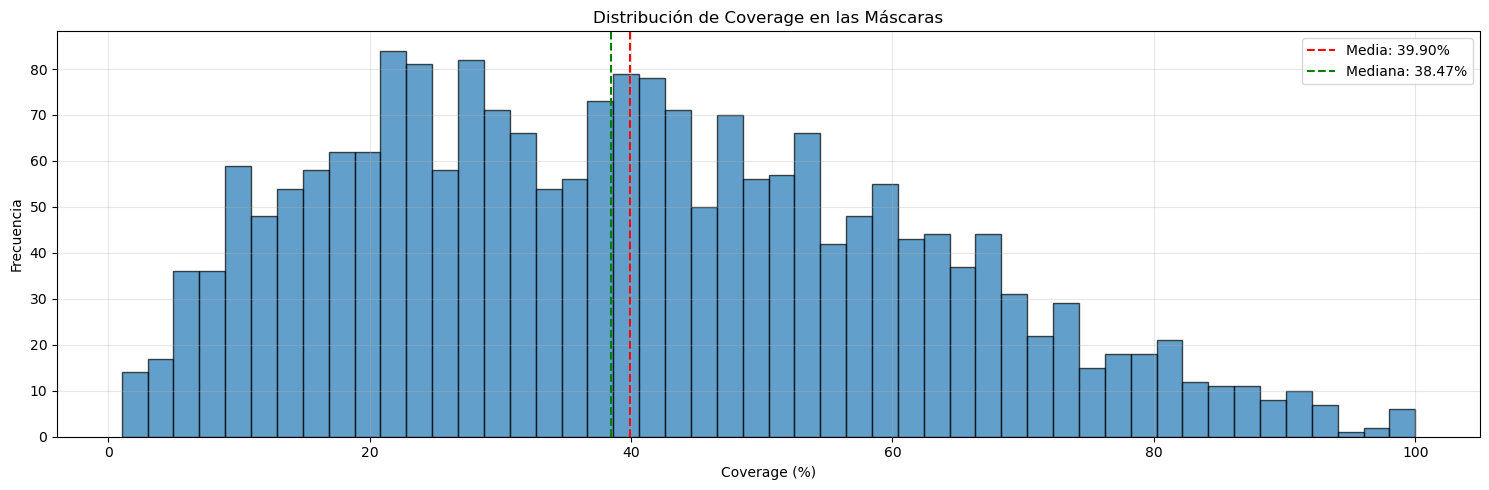

In [15]:
# Visualizamos la distribución de la cobertura
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Histograma
ax.hist(pct_cobertura, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(pct_cobertura), color='red', linestyle='--', label=f'Media: {np.mean(pct_cobertura):.2f}%')
ax.axvline(np.median(pct_cobertura), color='green', linestyle='--', label=f'Mediana: {np.median(pct_cobertura):.2f}%')

ax.set_xlabel('Coverage (%)')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Coverage en las Máscaras')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Las máscaras cubren en promedio un 40% de los píxeles del dataset. Como comentamos en el punto anterior, la región a segmentar suele ocupar una parte importante de la imagen, no son objetos diminutos.

Mirando imagen por imagen, la cobertura varía bastante: va desde alrededor de 1% hasta 100% de la imagen, con una media de ~40% y una mediana de ~38%. Esto nos dice que hay datos donde el objeto es muy chico y otras donde prácticamente ocupa toda la imagen.


## Decisiones de Preprocesamiento

Luego del análisis tomamos las siguientes decisiones para el preprocesamiento:

1. **Resize a (572x572)**: 
   - Pasamos de 800 x 800 a 572 x 572 basandonos en el tamaño que se utiliza en el paper para poder implementar la arquitectura lo mas similar posible manteniendo los tamaños.

2. **Normalizamos las máscaras**:
   - Nos aseguramos que sean estrictamente 0/1

4. **Data Augmentation**:
   - Tenemos un data set bastante pequeño, por lo que aplicaremos data augmentation al set de entrenamiento para aumentar variabilidad y mejorar la generalización.
   Probaramos simplemente transformando las imágenes en primera instancia y luego duplicando la cantidad de datos de entrenamiento. 

5. **Función de Pérdida**:
   - Si bien creemos que usar Dice como perdida dado el desbalance puede ser la mejor alternativa, probaremos tanto con esta como con BCE y combinaciones de ambas.
